**IMPORTATION DES DONNEES**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd 

# récupération des données nécessaires au K Means
data = pd.read_pickle('/content/drive/My Drive/Projet Info Grand débat/grand_debat_data.pk1')[["question", "parent", "tokens"]]

**ON TRANSFORME LA COLONNE TOKEN EN STRING POUR CALCULER LES SCORES TF IDF**

In [0]:
join_token = data.tokens.apply(lambda x: ' '.join(x))
data["join_token"] = join_token
data = data[data['join_token']!=""]
data

,question,parent,tokens,join_token
0,En qui faites-vous le plus confiance pour vous...,democratie,[citoyen],citoyen
1,Y a-t-il d'autres points sur la démocratie et ...,democratie,"[éviter, creuser, inégalité, augmenter, salair...",éviter creuser inégalité augmenter salaire pen...
2,En qui faites-vous le plus confiance pour vous...,democratie,"[instrument, démocratie, local, moderniser, en...",instrument démocratie local moderniser enquête...
3,Y a-t-il d'autres points sur la démocratie et ...,democratie,"[proposer, limitation, vitesse, réseau, second...",proposer limitation vitesse réseau secondaire ...
4,En qui faites-vous le plus confiance pour vous...,democratie,"[voir, intégralité, proposition, dernier, rubr...",voir intégralité proposition dernier rubrique ...
...,...,...,...,...
2435525,"Si vous avez été amené à chercher un emploi, p...",services,"[pole, emploi, inefficace]",pole emploi inefficace
2435526,Si vous avez été amené à préparer votre retrai...,services,"[reponse, telephoniqu, espace, retrait, cnav, ...",reponse telephoniqu espace retrait cnav nul bu...
2435527,Si vous avez été amené à demander un rembourse...,services,"[securite, social, compl, xe, controle, ineffi...",securite social compl xe controle inefficace
2435530,Si vous avez été amené à recruter du personnel...,services,"[urssaf, eleve, tarif]",urssaf eleve tarif


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import scipy.sparse.linalg as scl
import scipy.sparse as scs
from wordcloud import WordCloud
import matplotlib.pyplot as plt

**CHOISIR UNE CONDITION DE SELECTION DU VOCABULAIRE : LES MOTS LES PLUS PERTINENTS**

In [0]:
def selection(colonne_data, idf_value_max, idf_value_min):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(colonne_data) 
    # sparse matrice des TF IDF (lignes : reponses, colonnes : mots)
     
    idf = vectorizer.idf_
    index = np.arange(X.shape[0]) # vect de la taille du nbr de lignes de X (X.shape[0] = nbr de réponses traités)
    idx = np.arange(len(idf)) # vect de la taille du nbr de colonnes de X
    selected = idx[((idf_value_min < idf) & (idf < idf_value_max))] # indices des mots dont l idf verifie les contraintes
    troncatedX = X[:, selected]  # matrice X reduite aux mots dont l'idf verifie les contraintes

    print("array of tf-idf's shape after selecting dimentions:", troncatedX.shape)
    non_zeros_index = index[scl.norm(troncatedX, axis=1)!=0] # indice des réponses pour lesquelles la norme est non nulle
    non_zeros_troncated_X = troncatedX[non_zeros_index] # en plus d avoir réduit X aux mots selectionnés on la reduit aussi aux réponses de norme non nulle

    print("number of observations which are not rated 0 after dimention selection: ", non_zeros_index.shape)
    print("array shape: ", non_zeros_troncated_X.shape)
    
    words = {np.where(selected==indice)[0][0]:mot for mot, indice in vectorizer.vocabulary_.items() if indice in selected} # dico du vocabulaire du repertoire (reduit aux mots selectionnés), mots affectés en clé à leur indice dans selected

    return non_zeros_index, non_zeros_troncated_X, words

**FONCTION K MEANS**

In [0]:
def cosine_dist_sparse(U, V):
    return np.arccos(np.clip(U.dot(V.T)/(scl.norm(U, axis=1).reshape(-1,1) * scl.norm(V, axis=1).reshape(1,-1)),-1, 1))

def kmeans_cos(data,k,it=1000,dev=0.01):
    
    print("computing min and max")

    dmax= np.max(data, axis=0).toarray()[0]
    dmin= np.min(data, axis=0).toarray()[0]
    n, dim= data.shape

    centers = scs.csc_matrix(np.array([np.random.rand(dim)*(dmax-dmin) + dmin for i in range(k)])) # on créé les centres aléatoirement uniformement entre les bornes dmin dmax

    d=1
    i=0

    index = np.arange(n)

    print("start looping")
    while d > dev and i < it:

        dists = cosine_dist_sparse(data, scs.csc_matrix(centers))
        # (lignes:reponses) (colonnes:groupes)
        # dists est la matrice des distances entre un vecteur réponse et le vecteur centre

        g = np.argmin(dists, axis=1)
        # g indique pour chaque réponse le centre avec lequel elle est le plus proche

        m = np.zeros((k, dim))
        for l in range(k):
            c= np.array(g==l).T[0]
            m[l] = normalize(scs.vstack((data[c], centers[l])), axis=1).sum(axis=0)

        d = np.linalg.norm(centers - m) # on calcule la différence entre les anciens centres et les nouveaux
        centers = m # ce sera le point moyen des TF IDF par groupe
    
        i += 1
    print("loops done: ", i)

    return centers, g

**LA CONDITION SE FAIT SUR LES VALEURS DES IDF**

*CHOISIR LES BORNES*

In [0]:
borne_inferieure=4
borne_superieure=7.5

**APPLICATION**


**RETROUVER LES 4 GRANDS THEMES AVEC LE K MEANS**

In [0]:
nbr_groupes = 4

idx, X, vocab = selection(data["join_token"],borne_superieure,borne_inferieure)
 
c, g = kmeans_cos(X, nbr_groupes)

array of tf-idf's shape after selecting dimentions: (2384704, 1314)
number of observations which are not rated 0 after dimention selection:  (2188922,)
array shape:  (2188922, 1314)
1314
computing min and max
start looping
loops done:  20


**RESULTATS**

Cluster  0
democratie    67310
Name: parent, dtype: int64 

<class 'str'>
democratie 


Cluster  1
democratie    29960
Name: parent, dtype: int64 

<class 'str'>
democratie 


Cluster  2
democratie    78282
Name: parent, dtype: int64 

<class 'str'>
democratie 


Cluster  3
democratie    150115
Name: parent, dtype: int64 

<class 'str'>
democratie 


Cluster  4
democratie    59096
Name: parent, dtype: int64 

<class 'str'>
democratie 


Cluster  5
democratie    55640
Name: parent, dtype: int64 

<class 'str'>
democratie 




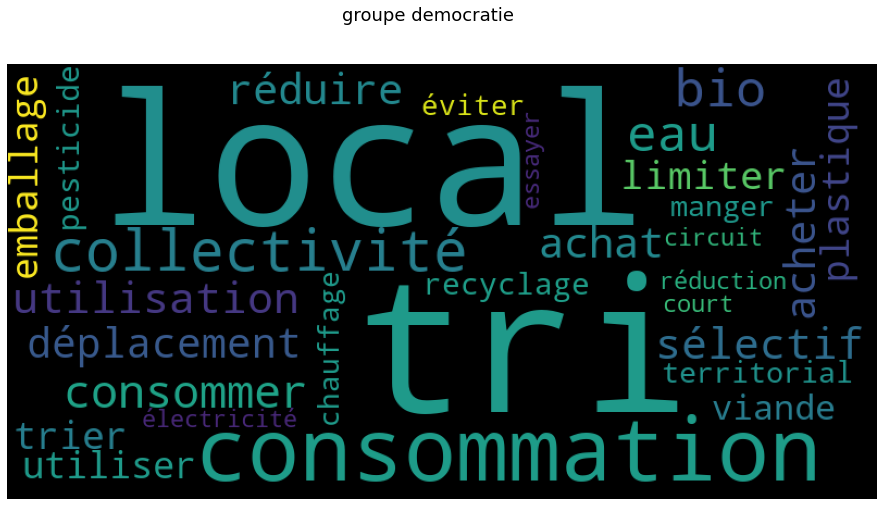

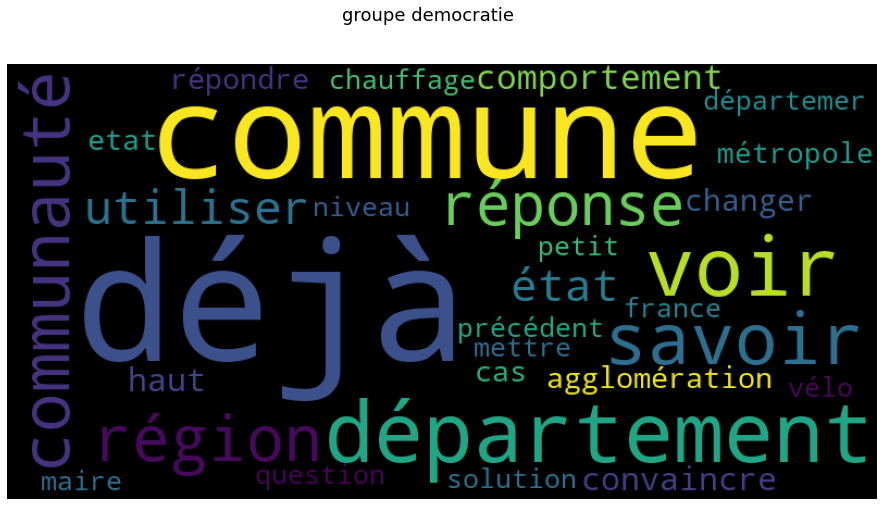

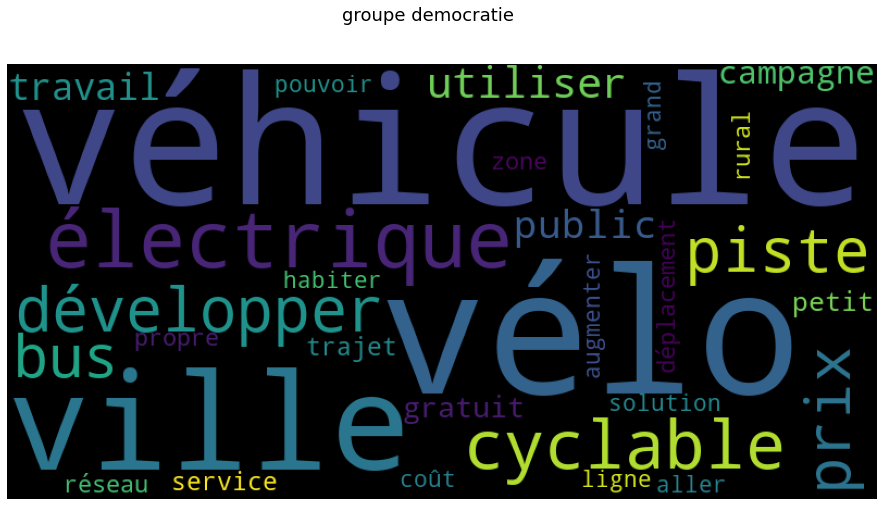

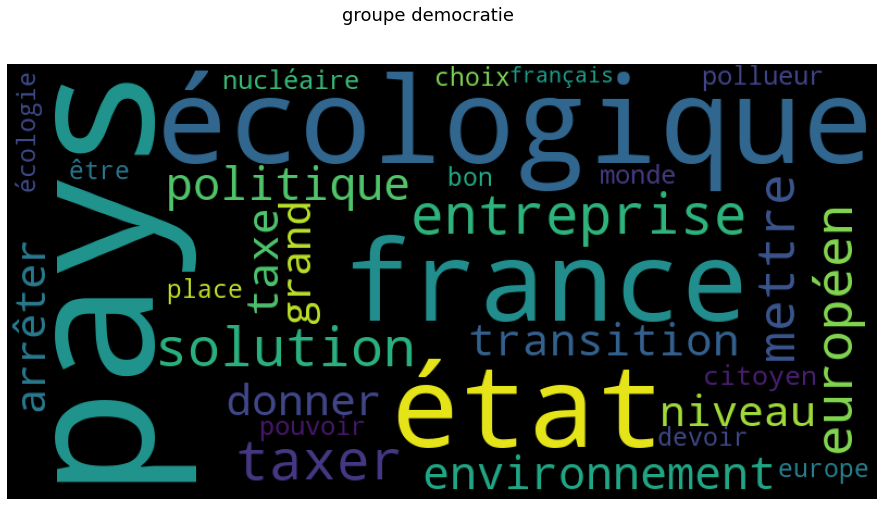

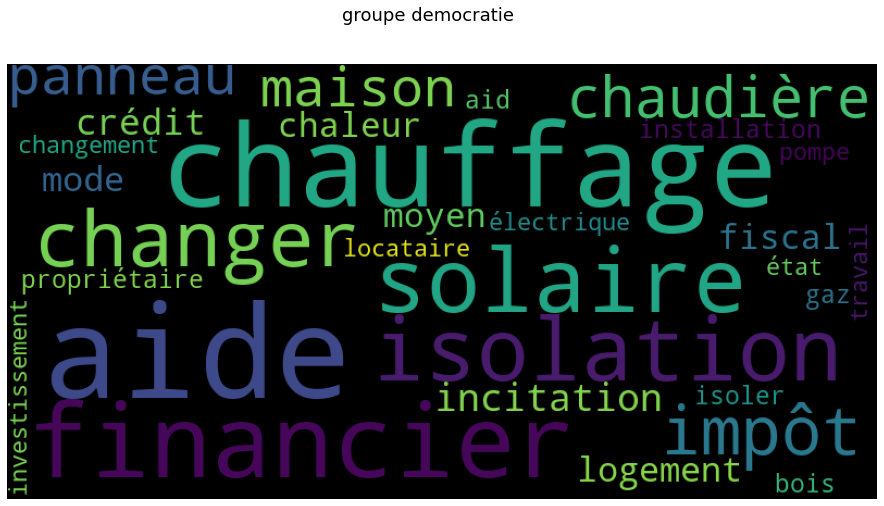

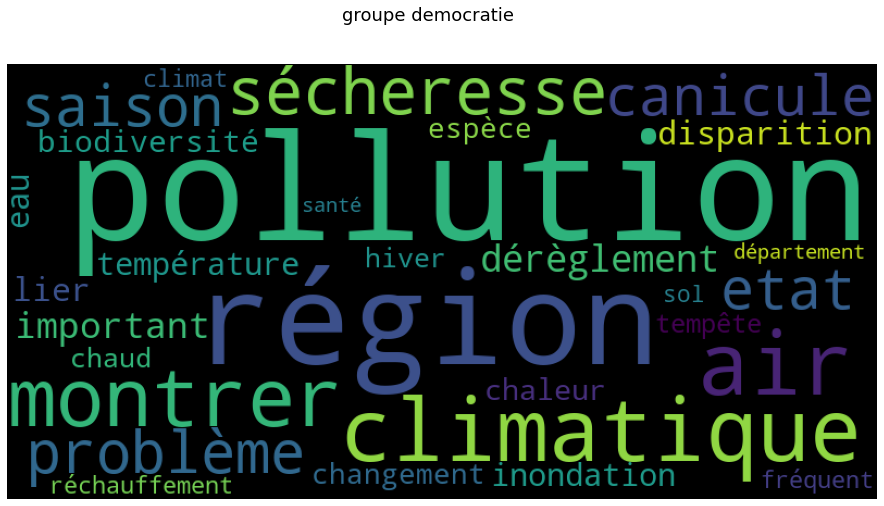

In [0]:
for i in range(nbr_groupes):
    print("Cluster ", i)
    print( data.iloc[idx[np.array(g.T)[0]==i]].parent.value_counts() ,"\n" )
    theme = data.iloc[idx[np.array(g.T)[0]==i]].parent.value_counts().index[0]
    print( theme, "\n\n" )

    indices = np.argpartition(-c[i], 30)[:30] # on récupère les indices des 30 mots dont le TF IDF est le plus grand

    freq = c[i][indices]/sum(c[i][indices])
    words = [vocab[i] for i in indices] # mot dont les indices ont été sélectionnés

    d = dict(zip(words,freq)) # on fait un dictionnaire avec pour chaque mot sa pondération
    img = WordCloud(width=800, height=400).generate_from_frequencies(d) # On retourne une image WordCloud

    plt.figure(figsize=(16, 8))
    plt.axis("off")
    plt.suptitle(f'groupe {theme}', fontsize=18) # title
    plt.imshow(img) 
    #plt.savefig("/content/drive/My Drive/Projet Info Grand débat/groupe{0}.png".format(theme))

**POUR UN THEME CHOISI, TROUVER DES SOUS THEMES AVEC LE K MEANS**

*CHOISIR LE THEME : FISCALITE, ECOLOGIE, DEMOCRATIE, SERVICES*

*CHOISIR LE NOMBRE DE GROUPES A FORMER*

*bons resultats entre 5 & 7 groupes pour ecologie*

*bons resultats entre 6 & 9 groupes pour services*

*bons resultats entre 4 & 7 groupes pour fiscalite*

*bons resultats entre 4 & 8 groupes pour democratie*

In [0]:
theme = 'ecologie'
nbr_groupes = 6

<class 'str'>


In [0]:
data_theme = data[data.parent==theme]

idx, X, vocab = selection(data_theme["join_token"],borne_superieure,borne_inferieure)

c, g = kmeans_cos(X, nbr_groupes)

array of tf-idf's shape after selecting dimentions: (497478, 1289)
number of observations which are not rated 0 after dimention selection:  (440403,)
array shape:  (440403, 1289)
1289
computing min and max
start looping
loops done:  24


**RESULTATS**

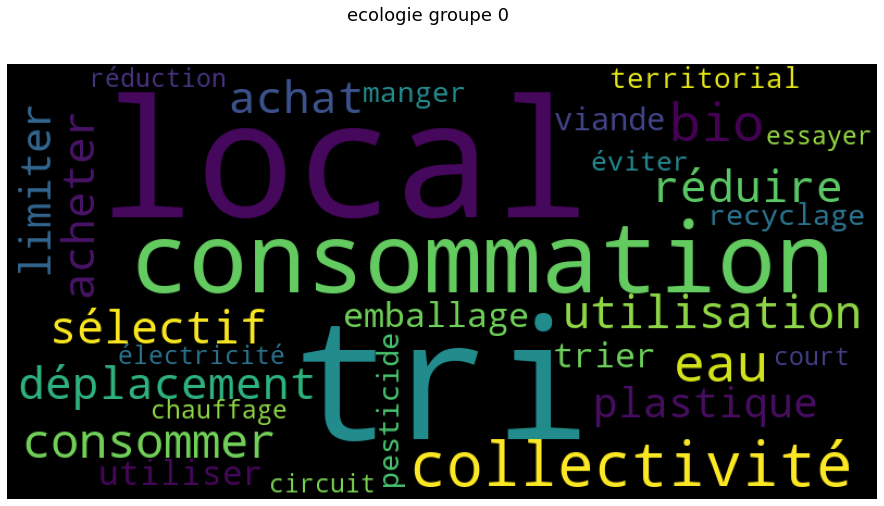

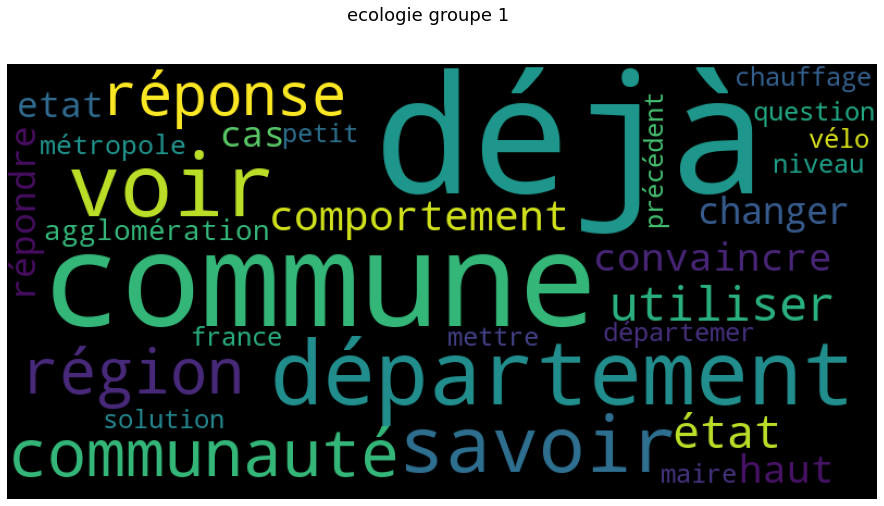

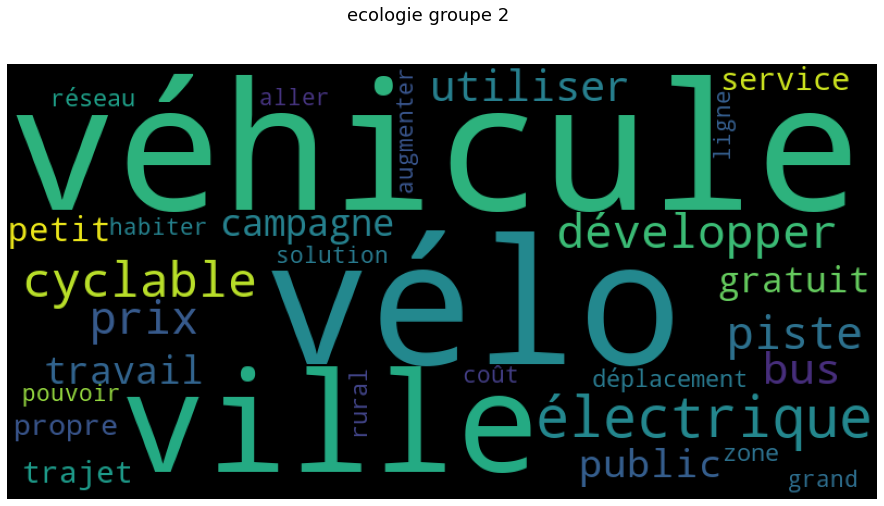

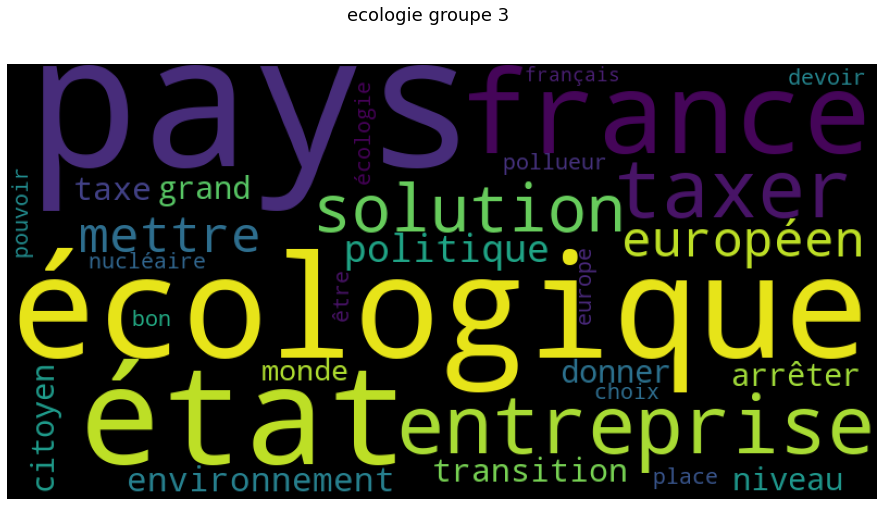

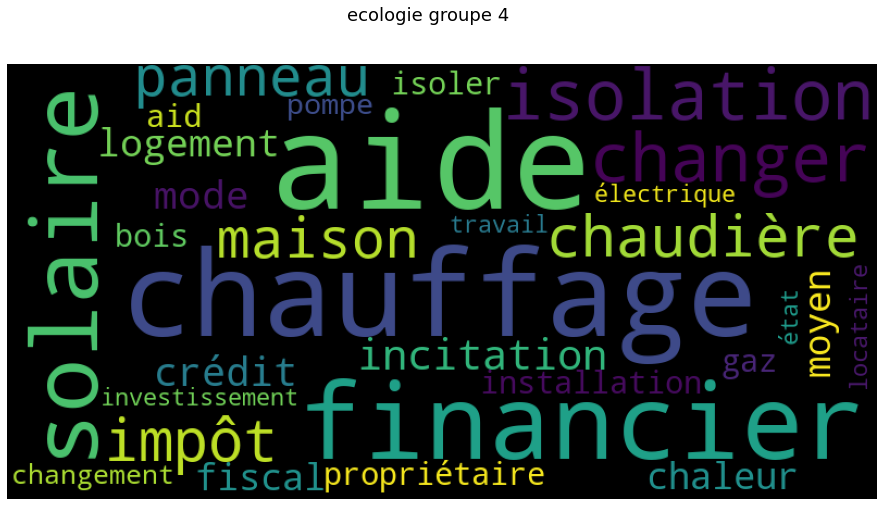

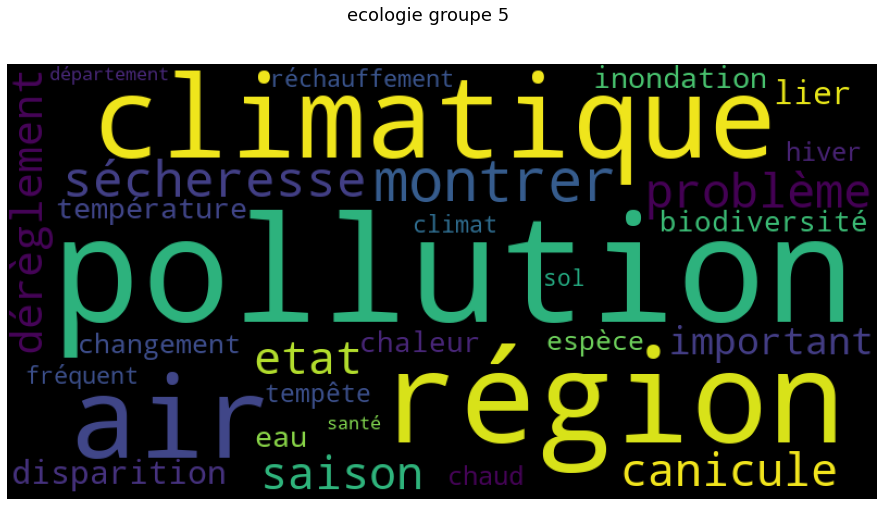

In [0]:
for i in range(nbr_groupes):

    indices = np.argpartition(-c[i], 30)[:30] # on récupère les indices des 30 mots dont le TF IDF est le plus grand

    freq = c[i][indices]/sum(c[i][indices])
    words = [vocab[i] for i in indices] # mot dont les indices ont été sélectionnés

    d = dict(zip(words,freq)) # on fait un dictionnaire avec pour chaque mot sa pondération
    img = WordCloud(width=800, height=400).generate_from_frequencies(d) # On retourne une image WordCloud

    plt.figure(figsize=(16, 8))
    plt.axis("off")
    plt.suptitle(f'{theme} groupe {i}', fontsize=18) # title
    plt.imshow(img)   
    plt.savefig(f'/content/drive/My Drive/Projet Info Grand débat/{theme} groupe {i}.png')

**EVALUER LE POURCENTAGE DE MOTS COMMUNS ENTRE UN DOSSIER PARENT ET LES AUTRES**

In [0]:
def in_both(data1, data2, intervalle_nbr_mots : tuple):

    vectorizer = TfidfVectorizer(min_df=1)

    vectorizer.fit_transform(data1)

    words1 = vectorizer.get_feature_names() # On récupère la liste de mots
    idf1 = vectorizer.idf_ # On récupère la liste des IDFs
    
    index1 = np.argpartition(idf1, intervalle_nbr_mots)[intervalle_nbr_mots[0]:intervalle_nbr_mots[1]] # On récupère les indices des idf dans l'intervalle_nbr des idf classés dans l'ordre croissant

    d1 = np.take(words1, index1)

    vectorizer.fit_transform(data2)

    words2 = vectorizer.get_feature_names() # On récupère la liste de mots
    idf2 = vectorizer.idf_ # On récupère la liste des IDFs
    
    index2 = np.argpartition(idf2, intervalle_nbr_mots)[intervalle_nbr_mots[0]:intervalle_nbr_mots[1]] # On récupère les indices des idf dans l'intervalle_nbr des idf classés dans l'ordre croissant

    d2 = np.take(words2, index2)

    return set(d1) & set(d2)

**CHOISIR LE NOMBRE DE MOTS ET LE DOSSIER PARENT (fiscalite, ecologie, services, democratie)**

In [0]:
nbr_mots = (32,1346)
dossier_parent = 'ecologie'
treated_Text1 = data[data.parent==dossier_parent].tokens.apply(lambda x: ' '.join(x)).to_list()   
treated_Text2 = data[data.parent!=dossier_parent].tokens.apply(lambda x: ' '.join(x)).to_list()      
similar = in_both(treated_Text1, treated_Text2, nbr_mots)

In [0]:
pourcentage=len(similar)/(nbr_mots[1]-nbr_mots[0])*100
print("nombre de mots communs entre {0} et les mots provenant des autres fichiers:".format(dossier_parent),len(similar),"  {0}%".format(pourcentage))

nombre de mots communs entre ecologie et les mots provenant des autres fichiers: 788   59.96955859969558%


**TESTS SUR LES DOSSIERS PARENTS (fiscalite, ecologie, services, democratie)**

 *POUR LES CONTRAINTES IDF CHOISIES (4 < IDF < 7.5)*

In [0]:
def get_smallest_idf(data, intervalle_nbr : tuple):
 
    vectorizer = TfidfVectorizer(min_df=1)

    vectorizer.fit_transform(data)

    words1 = vectorizer.get_feature_names() # On récupère la liste de mots
    idf1 = vectorizer.idf_ # On récupère la liste des IDFs
    
    index1 = np.argpartition(idf1, intervalle_nbr)[intervalle_nbr[0]:intervalle_nbr[1]] # On récupère les indices des idf dans l'intervalle_nbr des idf classés dans l'ordre croissant

    return np.take(words1, index1)

In [0]:
treated_Text_services = data[data.parent=='services'].tokens.apply(lambda x: ' '.join(x)).to_list() 
words_services = get_smallest_idf(treated_Text_services, nbr_mots)

treated_Text_fiscalite = data[data.parent=='fiscalite'].tokens.apply(lambda x: ' '.join(x)).to_list() 
words_fiscalite = get_smallest_idf(treated_Text_fiscalite, nbr_mots)

treated_Text_democratie = data[data.parent=='democratie'].tokens.apply(lambda x: ' '.join(x)).to_list() 
words_democratie = get_smallest_idf(treated_Text_democratie, nbr_mots)

treated_Text_ecologie = data[data.parent=='ecologie'].tokens.apply(lambda x: ' '.join(x)).to_list() 
words_ecologie = get_smallest_idf(treated_Text_ecologie, nbr_mots)

print( 'parmi les mots du vocabulaire selectionné, il y a : \n\n')

print(  len( set(words_services)&set(words_fiscalite)&set(vocab.values()) ) / len( set(words_services)&set(vocab.values()) ) * 100,"% de services dans fiscalite"  )
print(  len( set(words_services)&set(words_democratie)&set(vocab.values()) ) / len( set(words_services)&set(vocab.values()) ) * 100,"% de services dans democratie"  )
print(  len( set(words_services)&set(words_ecologie)&set(vocab.values()) ) / len( set(words_services)&set(vocab.values()) ) * 100,"% de services dans ecologie\n"  )

print(  len( (set(words_services)&set(vocab.values())) - ( set(vocab.values())&(set(words_fiscalite)|set(words_democratie)|set(words_ecologie)) ) ) / len( set(words_services)&set(vocab.values()) )*100,"% de services specifique\n\n"  )

print(  len( set(words_fiscalite)&set(words_democratie)&set(vocab.values()) ) / len( set(words_fiscalite)&set(vocab.values()) ) * 100,"% de fiscalite dans democratie" )
print(  len( set(words_fiscalite)&set(words_ecologie)&set(vocab.values()) ) / len( set(words_fiscalite)&set(vocab.values()) ) * 100,"% de fiscalite dans ecologie" )
print(  len( set(words_fiscalite)&set(words_services)&set(vocab.values()) ) / len( set(words_fiscalite)&set(vocab.values()) ) * 100,"% de fiscalite dans services\n" )

print(  len( (set(words_fiscalite)&set(vocab.values())) - ( set(vocab.values())&(set(words_services)|set(words_democratie)|set(words_ecologie)) ) ) / len( set(words_fiscalite)&set(vocab.values()) ) * 100,"% de fiscalite specifique\n\n"  )

print(  len( set(words_democratie)&set(words_ecologie)&set(vocab.values()) ) / len( set(words_democratie)&set(vocab.values()) ) * 100,"% de democratie dans ecologie"  )
print(  len( set(words_democratie)&set(words_services)&set(vocab.values()) ) / len( set(words_democratie)&set(vocab.values()) ) * 100,"% de democratie dans services"  )
print(  len( set(words_democratie)&set(words_fiscalite)&set(vocab.values()) ) / len( set(words_democratie)&set(vocab.values()) ) * 100,"% de democratie dans fiscalite\n"  )

print(  len( (set(words_democratie)&set(vocab.values())) - ( set(vocab.values())&(set(words_fiscalite)|set(words_services)|set(words_ecologie)) ) ) / len( set(words_democratie)&set(vocab.values()) ) * 100,"% de democratie specifique\n\n"  )

print(  len( set(words_ecologie)&set(words_services)&set(vocab.values()) ) / len( set(words_ecologie)&set(vocab.values()) ) * 100,"% de ecologie dans services"  )
print(  len( set(words_ecologie)&set(words_fiscalite)&set(vocab.values()) ) / len( set(words_ecologie)&set(vocab.values()) ) * 100,"% de ecologie dans fiscalite"  )
print(  len( set(words_ecologie)&set(words_democratie)&set(vocab.values()) ) / len( set(words_ecologie)&set(vocab.values()) ) * 100,"% de ecologie dans democratie\n"  )

print(  len( (set(words_ecologie)&set(vocab.values())) - ( set(vocab.values())&(set(words_fiscalite)|set(words_democratie)|set(words_services)) ) ) / len( set(words_ecologie)&set(vocab.values()) ) * 100,"% de ecologie specifique"  )

parmis les mots du vocabulaire selectionné, il y a : 


85.25576730190572 % de services dans fiscalite
86.65997993981945 % de services dans democratie
71.51454363089267 % de services dans ecologie

2.6078234704112337 % de services specifique


81.82720953326714 % de fiscalite dans democratie
74.37934458788482 % de fiscalite dans ecologie
84.40913604766634 % de fiscalite dans services

3.7735849056603774 % de fiscalite specifique


70.7631318136769 % de democratie dans ecologie
85.62933597621407 % de democratie dans services
81.66501486620416 % de democratie dans fiscalite

5.2527254707631315 % de democratie specifique


79.13429522752497 % de ecologie dans services
83.12985571587126 % de ecologie dans fiscalite
79.24528301886792 % de ecologie dans democratie

7.547169811320755 % de ecologie specifique
